# Isothermal decompression calculations

- In addition to crystallization and melting calculations, thermodynamic models are often used to investigate the processes of magma decompression.
- In this notebook we focus on the fluid composition during magma decompression by investigating different initial H2O contents.

**Before any calculations can be run** users need to download the alphaMELTS for Python files. Please see the installation guide on ReadTheDocs.

In [1]:
# import core python packages that we'll use for plotting and data manipulation.
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PetThermoTools as ptt 

ptt.__version__

'0.2.45'

To suppress outputs from the MELTS calculations run the cell below twice.

In [3]:
## If using Mac run this cell **twice** 
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

In this example we'll load melt inclusion compositions from the White Pumice of Mt St Helens published the study of Blundy and Cashman (2005).

In [4]:
# Melt inclusion and groundmass glass data from Mt St Helens (Blundy and Cashman, 2005)
StHelens = pd.read_excel('StHelens.xlsx', sheet_name='1980_WhitePumice')
StHelens = StHelens.fillna(0.0)
StHelens.head()

,sample,Type,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,H2O,Total
0,KCHB-4Aa,A1,68.05,0.33,12.96,2.72,0.12,0.98,1.95,5.60,1.93,4.63,99.26
1,KCHB-7Ab,A1,69.01,0.37,14.07,2.19,0.02,0.36,2.25,5.54,1.85,3.19,99.09
2,KCHB-8Aa,A1,70.19,0.35,14.70,2.52,0.03,0.34,2.24,6.51,1.72,1.83,100.43
3,KCHB-I IR,A1,65.81,0.51,15.03,2.13,0.00,0.37,2.35,5.65,2.44,4.92,99.2
4,KCHB-I IB',A1,69.71,0.21,14.15,2.48,0.00,0.45,2.23,6.39,2.03,2.66,100.29


For these simple decompression calculations we can simply pick any of the inclusions from the Blundy and Cashman (2005) study. Here we select a plagioclase-hosted melt incluion:

In [5]:
# select a representative composition of the Mt St Helens white pumice. Here we've chosen a more mafic (~65 wt% SiO2) water rich inclusion.
WhitePumice = StHelens.loc[23]
WhitePumice

sample    006-IOAO
Type            PI
SiO2         64.91
TiO2          0.41
Al2O3        13.31
FeOt          2.78
MnO           0.02
MgO           0.71
CaO           1.95
Na2O          5.49
K2O           1.99
H2O           6.38
Total        98.27
Name: 23, dtype: object

The inclusion has a measured H2O content of 6.38 wt%, but it is worth investigating how the degassing behaviour - and volatile composition - might change with different assumed initial CO2 contents. In the following cell we set up a decompression calculation using the measured H2O content and 4 different initial CO2 contents (in wt%).

In [6]:
Helens_decompress = ptt.isothermal_decompression(Model="MELTSv1.2.0", 
    bulk=WhitePumice, find_liquidus=True, fO2_buffer="FMQ", fO2_offset=2, 
    P_start_bar=3000, P_end_bar=50, dp_bar=20, fluid_sat = True,
    CO2_init = np.array([0.001, 0.01, 0.025, 0.05]),  label = 'CO2')

We can inspect the outputs and see that each run is now labeled by the initial CO2 content of that model.

In [7]:
Helens_decompress.keys()

dict_keys(['CO2 = 0.001 wt%', 'CO2 = 0.01 wt%', 'CO2 = 0.025 wt%', 'CO2 = 0.05 wt%'])

Examining the results from one model reveals the various Dictionaries and Pandas DataFrames that are created during the thermodynamic calculations.

In [8]:
Helens_decompress['CO2 = 0.01 wt%'].keys()

dict_keys(['Conditions', 'liquid1', 'liquid1_prop', 'fluid1', 'fluid1_prop', 'spinel1', 'spinel1_prop', 'plagioclase1', 'plagioclase1_prop', 'All', 'Mass', 'Volume', 'rho', 'Input'])

Specifically focusing on the fluid, we can use the cell below to examine the composition of the fluid phase for a single model.

In [9]:
Helens_decompress['CO2 = 0.05 wt%']['fluid1'].head()

,H2O_Fl,CO2_Fl,X_H2O_mol_Fl,X_CO2_mol_Fl
0,67.097841,32.902159,0.832915,0.167085
1,67.578631,32.421369,0.835936,0.164064
2,68.066036,31.933964,0.838976,0.161024
3,68.560116,31.439884,0.842035,0.157965
4,69.060924,30.939076,0.845115,0.154885


We can further examine the results by plotting up the fluid composition against pressure. In the cell below we can loop through the main results Dictionary to access each model in turn.

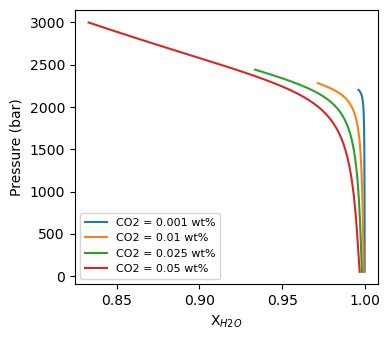

In [11]:
# set up figure layout
f, a = plt.subplots(1,1, figsize = (4,3.5))

# loop through main Dictionary
for key in Helens_decompress:
    # extract individial calculations
    res = Helens_decompress[key]

    # plot fluid chemistry vs pressure
    a.plot(res['All']['X_H2O_mol_Fl'],
        res['All']['P_bar'],'-',label=key)

a.legend(fontsize = 8)

a.set_xlabel('X$_{H2O}$')
a.set_ylabel('Pressure (bar)')

f.tight_layout()